# Zindi Data Science Challenge: Agricultural Keyword Spotter: Preprocessing

In [1]:
import pandas as pd #
import matplotlib.pyplot as plt #
import numpy as np #
import librosa
import tifffile
import IPython.display as ipd
import pickle
import os
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow as naf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import sys  
sys.path.insert(0, './pycharm_zindi_keyword_spotter')

from preprocess import *

## Training Set

### Structuring how files are stored

The data for this challenge consists of a few thousand audio files that each include one agricultural keyword in English or Luganda. 

The data is provided in three different folders:`audio_files` (which also includes the test audio files),`nlp_keywords`, and `latest_keywords`. The names of the training audio files along with their labels in the folder audio_files is found in the CSV file `Train.csv`. The other training files (i.e. those in the folders `nlp_keywords` and `latest_keywords`) are not recorded in the CSV file. Instead, both folders have sub-folders named after the label of audio files it contains.

Hence, in the preprocessing of the training set, I create one dataframe that includes the names of all training audio files and their corresponding label. This makes it easier for me to access each file in the training set.

In [3]:
audio_files = pd.read_csv("Train.csv")

Since the lables are given as strings, I map each of them as a numeric label and store the mapping in the dictionaries `labels_mapping` and `labels_numeric_mapping` (which I then save as pickle for later use).

In [4]:
labels_mapping, labels_numeric_mapping = map_labels(audio_files, 'label')

In [5]:
save_as_pickle('./pickles/labels_numeric_mapping', labels_numeric_mapping)

In [6]:
audio_files['label_num'] = audio_files['label'].map(labels_mapping)
audio_files.head()

,fn,label,label_num
0,audio_files/IV38R7F.wav,akawuka,0
1,audio_files/KM4SKWT.wav,banana,1
2,audio_files/F5POSU9.wav,obulwadde,2
3,audio_files/MMVDXG2.wav,nnyaanya,3
4,audio_files/9TVM96F.wav,pampu,4


In [7]:
nlp_keywords_df = get_df_from_file("nlp_keywords/")
nlp_keywords_df.head()

,fn,label
0,nlp_keywords/okulimibwa/6fbfcce2cf21419e97290f...,okulimibwa
1,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa
2,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa
3,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa
4,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa


In [8]:
latest_keywords_df = get_df_from_file("latest_keywords/")
latest_keywords_df.head()

,fn,label
0,latest_keywords/okulimibwa/5aa4893526794a73a3e...,okulimibwa
1,latest_keywords/okulimibwa/1b5a69c4b88b41eb957...,okulimibwa
2,latest_keywords/okulimibwa/1b5a69c4b88b41eb957...,okulimibwa
3,latest_keywords/okulimibwa/eb702740d41f4f38919...,okulimibwa
4,latest_keywords/okulimibwa/1b5a69c4b88b41eb957...,okulimibwa


In [9]:
keywords = nlp_keywords_df.append(latest_keywords_df).reset_index().drop(columns='index')
keywords['label_num'] = keywords['label'].map(labels_mapping)

keywords.head()

,fn,label,label_num
0,nlp_keywords/okulimibwa/6fbfcce2cf21419e97290f...,okulimibwa,8
1,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa,8
2,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa,8
3,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa,8
4,nlp_keywords/okulimibwa/d027264654b94950aeb204...,okulimibwa,8


In [10]:
train = audio_files.append(keywords).reset_index().drop(columns='index')

In [11]:
train.head()

,fn,label,label_num
0,audio_files/IV38R7F.wav,akawuka,0
1,audio_files/KM4SKWT.wav,banana,1
2,audio_files/F5POSU9.wav,obulwadde,2
3,audio_files/MMVDXG2.wav,nnyaanya,3
4,audio_files/9TVM96F.wav,pampu,4


### Getting a sense for the data

As can be seen above, the dataset includes quite few examples given how many classes there are.

In [12]:
print('Number of training examples:', len(train))
print('Number of classes:', train.label.nunique())

Number of training examples: 4709
Number of classes: 193


The histogram below clarifies what I've expected from the numbers above: There are over 60 classes with less than ten files per class. And the majority of classes have less than 35 files per class.

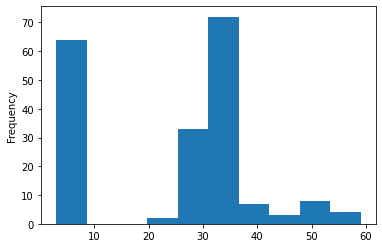

In [13]:
train.groupby('label').count()['fn'].plot(kind='hist');

Okay, enough about numbers. Let's have a look (and hear) at the audio.

After doing some research about how best to handle auido data, I decided to extract features from the audio files by creating mel spectrograms and treat the problem at hand as an image classification problem. 

For more detail about mel spectrograms and audio classification with CNNs, I recommend the following two articles here: 
- https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
- https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

To see how the keywords in the audio files look like in mel spectrograms, I visualize all the mel spectrograms with the label 'banana'. The differ quite a lot from each other. However, at least in the last two images, you can vaguely recognize the three sillables the word 'banana' conists of. 

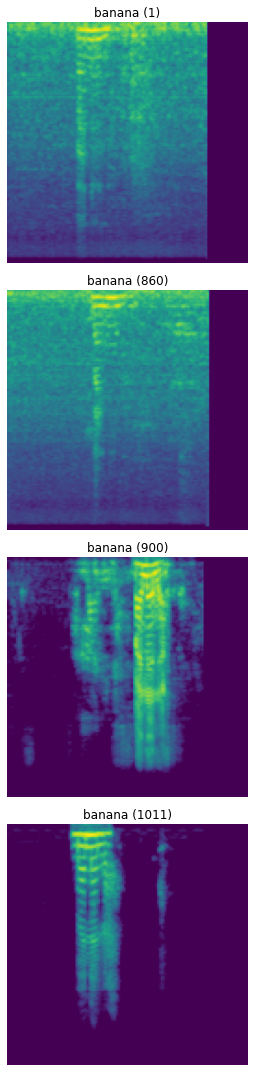

In [14]:
get_image_for_label(train, 'banana')

Since humans don't have a good intuition about mel spectrograms, here are the audio files for the word 'banana' for you to listen to.

In [15]:
paths = list(train.fn)

In [16]:
ipd.Audio(paths[1])

In [17]:
ipd.Audio(paths[860])

In [18]:
ipd.Audio(paths[900])

In [19]:
ipd.Audio(paths[2000])

To make training faster, I save all mel spectrograms to the folder `spectrograms`.

In [ ]:
for i in range(len(paths)):
    output_file = paths[i].split('/')[-1].split('.wav')[0]
    output_file = output_file + '.tif'
    tifffile.imwrite('./spectrograms/' + output_file, get_melspectrogram(paths[i]))

I also want to store the names of the TIF files in the dataframe `train`, so that during training I can easily access the images via the Dataset and DataLoader.

In [20]:
image_names = [path.split('/')[-1].split('.wav')[0] + '.tif' for path in paths]

In [21]:
train['image'] = image_names
train = train[['fn', 'image', 'label', 'label_num']].copy()
train.sample(5)

,fn,image,label,label_num
2687,nlp_keywords/munyeera/d027264654b94950aeb204f6...,d027264654b94950aeb204f64d05d8d7_443be618a0f14...,munyeera,20
1357,nlp_keywords/eggobe/d027264654b94950aeb204f64d...,d027264654b94950aeb204f64d05d8d7_6c5c0497217a4...,eggobe,21
2141,nlp_keywords/ebirime/6fbfcce2cf21419e97290f9e1...,6fbfcce2cf21419e97290f9e12934f65_d8b1daead7fc4...,ebirime,33
1029,audio_files/XO1W6CU.wav,XO1W6CU.tif,amakungula,124
3447,latest_keywords/emiyembe/771b5044334242fb9caff...,771b5044334242fb9caff8a71fd7891e_d6e41683e2394...,emiyembe,144


In [22]:
train.to_csv('train_paths.csv')

## Test set

The audio files for testing are also stored in the folder `audio_files` and are recorded in the CSV file `SampleSubmission.csv`. Since those examples are used for testing and evaluating the model on the public leaderboard, they do not come with a label. Instead, each class should be given a probability for each audio file in the test set.

In [23]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,ensukusa,maize stalk borer,amakoola,muceere,insect,pumpkin,spray,namuginga,tomatoes,akatungulu,ground nuts,orange,nursery bed,npk,mangoes,ebitooke,maize,endwadde,lumonde,ensiringanyi,pawpaw,ebijjanjalo,sukumawiki,caterpillars,matooke seedlings,okusaasaana,omuceere,ebikajjo,mulimi,sikungula,watermelon,ennima,akammwanyi,amakungula,ebyobulimi,okugimusa,sow,Pump,ekigimusa,ekirime,okusiga,nfukirira,faamu,okulimibwa,pampu,vegetables,lusuku,ennyaanya,ekisaanyi,bibala,ekikajjo,ennimiro,okukungula,akatunda,eppapaali,endagala,ekijanjaalo,abalimi,plant,Spinach,ndwadde,caterpillar,miceere,farmer,irrigate,nnakati,omusiri,weeding,okusaasaanya,amalagala,ekikoola,ebisooli,munyeera,ekirwadde,enkota,banana,fruit picking,ebibala,dig,doodo,omulimisa,eggobe,seed,crop,okunnoga,obutunda,fruit,endokwa,ebikolo,omucungwa,okufukirira,obulwadde,ebijanjaalo,matooke,pepper,agriculture,afukirira,nnyaanya,medicine,nambaale,cassava,sugarcane,ekimera,kikajjo,obusaanyi,ekibala,ebigimusa,kukungula,nnimiro,ebikongoliro,irish potatoes,ensuku,emicungwa,ekikolo,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
print('Number of test examples:', len(ss))

Number of test examples: 1017


In [25]:
ss_num = ss.rename(columns=labels_mapping)

In [26]:
test_paths = list(ss.fn)

As I did with the audio files for training/validation, I also save the mel spectrograms of the test audio files.

In [ ]:
for i in range(len(test_paths)):
    output_file = test_paths[i].split('/')[-1].split('.wav')[0]
    output_file = output_file + '.tif'
    tifffile.imwrite('./test_spectrograms/' + output_file, get_melspectrogram_from_path(test_paths[i]))

## Data Augmentation

Since there are so few training examples, I decide to augment my data. As far as I have understood, you can augment audio data in two ways. Either you alter the audio itself (e.g. shift the pitch, stretch it, speed it up,...) or you augment the mel spectrograms.

After some experiments, I settled for the second way. In addition, augmenting the mel spectrograms means that the augmentation can be built into the Dataset, and so each image is randomly augmented when drawn by the DataLoader.

To augment the mel spectrograms, I used a method called SpecAugmet (https://arxiv.org/pdf/1904.08779.pdf) via the `nlpaug` library (https://nlpaug.readthedocs.io/en/latest/index.html)

To demonstrate how SpecAugment works, I apply two of its augmentations (Frequency Masking and Time Masking) to a single mel spectrogram below:

In [27]:
my_data = tifffile.imread('spectrograms/' + train.image[0])

Frequency Masking:

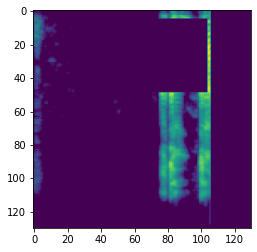

In [28]:
aug = nas.FrequencyMaskingAug(zone=(0.2, 0.8))
aug_data = aug.substitute(my_data)
plt.imshow(aug_data);

Time Masking:

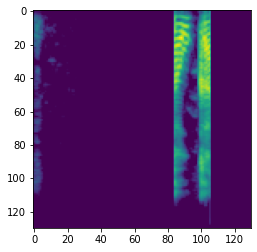

In [29]:
aug = nas.TimeMaskingAug(zone=(0.2, 0.8))
aug_data = aug.substitute(my_data)
plt.imshow(aug_data);

Combination of Frequency and Time Masking:

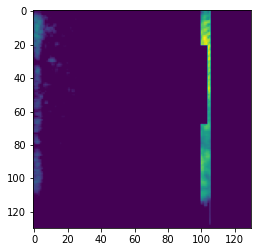

In [38]:
flow = naf.Sequential([
    nas.FrequencyMaskingAug(), 
    nas.TimeMaskingAug()])

my_data = tifffile.imread('spectrograms/' + train.image[0])
aug_data = flow.augment(my_data)
plt.imshow(aug_data);